<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/period-and-revolution-time-rigid-pendulum-EarthPurse/blob/main/solve_ivp_events_and_quad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-209057256.py:64: RuntimeWarning: invalid value encountered in sqrt
  return 1 / np.sqrt(1 - (E - np.cos(theta)))
/tmp/ipython-input-209057256.py:65: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rev, _ = quad(revolution_integrand, 0, 2*np.pi, args=(E, omega_0))
/tmp/ipython-input-209057256.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


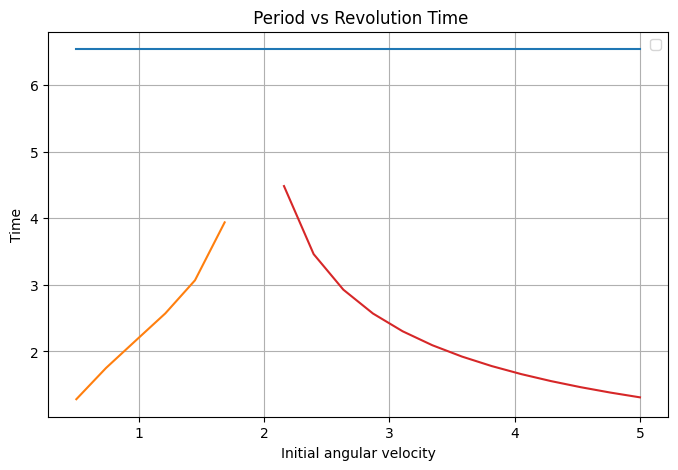

In [12]:
from re import A
from typing_extensions import TypeVarTuple
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad

# define the regid pendulum ODE
def rigid_pendulum_ode (t, y, omega_0=1):
  """
  y = [theta, ang_vel]
  """
  theta, ang_vel = y
  dtheta_dt = ang_vel
  d2theta_dt2 = -omega_0**2 * np.sin(theta)
  return [dtheta_dt, d2theta_dt2]

# define revolution time and period
def period (theta, theta_0, omega_0=1):
  coeff = 4 / (np.sqrt(2) * omega_0)
  denom = np.sqrt(np.cos(theta) - np.cos(theta_0))
  return coeff / denom

def revolution_time (theta, E, omega_0=1):
  """
  Revolutioon time integral (full 2π sweep)
  """
  coeff =1 / omega_0
  denom = np.sqrt(1 - (E - np.cos(theta)))
  return coeff / denom

# functions for solve_ivp
def event_peak(t, y, *args):
  return y[1]
event_peak.direction = -1
event_peak.terminal = True

def event_revolution (t, y, *args):
  return y[0] - 2*np.pi
event_revolution.direction = 1
event_revolution.terminal = True

# plotting
def basic_plot(x, y, xlabel=None, ylabel=None, label=None):
  plt.plot(x, y, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.grid(True)

# now usiing "quad" integral method
def compute_period_integral(theta_0, omega_0=1):
  # Need to define period_integrand first
  def period_integrand(theta, theta_0, omega_0):
      return 1 / np.sqrt(np.cos(theta) - np.cos(theta_0))
  period, _ = quad(period_integrand, 0 ,theta_0, args=(theta_0, omega_0))
  return 4 * period / (np.sqrt(2) * omega_0)


def compute_revolution_integral(theta_0, omega_0=1):
  E = np.cos(theta_0)
  # Need to define revolution_integrand first
  def revolution_integrand(theta, E, omega_0):
      return 1 / np.sqrt(1 - (E - np.cos(theta)))
  rev, _ = quad(revolution_integrand, 0, 2*np.pi, args=(E, omega_0))
  return rev / omega_0

# now using "solve_ivp + events"
def compute_period_ode(theta_0, ang_vel_0, omega_0=1):
  y0 = [theta_0, ang_vel_0]
  sol = solve_ivp(rigid_pendulum_ode, [0, 50], y0,
                  args=(omega_0,), events=event_peak, max_step=0.01)
  if sol.t_events[0].size > 0:
    # The period is the time to reach the peak from the start, multiplied by 2 (for a full oscillation)
    return 2 * sol.t_events[0][0]
  else:
    return None

def compute_revolution_ode(theta_0, ang_vel_0, omega_0=1):
  y0 = [0, ang_vel_0]
  sol = solve_ivp(rigid_pendulum_ode, [0, 50], y0,
                  args=(omega_0,), events=event_revolution, max_step=0.01)
  if sol.t_events[0].size > 0:
    return sol.t_events[0][0]
  else:
    return None

#velocities
omega_0 = 1
ang_vel_list = np.linspace(0.5, 5, 20)
T_int_list = []
T_rev_int_list = []
T_ode_list = []
T_rev_ode_list = []

for ang_vel in ang_vel_list:
    theta_0 = np.pi/4
    T_int = compute_period_integral(theta_0, omega_0)
    T_rev_int = compute_revolution_integral(theta_0, omega_0)
    T_ode = compute_period_ode(theta_0, ang_vel, omega_0)
    T_rev_ode = compute_revolution_ode(theta_0, ang_vel, omega_0)
    T_int_list.append(T_int)
    T_rev_int_list.append(T_rev_int)
    T_ode_list.append(T_ode)
    T_rev_ode_list.append(T_rev_ode)

# Plot
plt.figure(figsize=(8,5))
basic_plot(ang_vel_list, T_int_list, xlabel='Initial angular velocity', ylabel='Time')
basic_plot(ang_vel_list, T_ode_list, xlabel='Initial angular velocity', ylabel='Time')
basic_plot(ang_vel_list, T_rev_int_list, xlabel='Initial angular velocity', ylabel='Time')
basic_plot(ang_vel_list, T_rev_ode_list, xlabel='Initial angular velocity', ylabel='Time')
plt.title(" Period vs Revolution Time")
plt.show()